In [2]:
import pandas as pd
import transformers
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax


In [3]:
df=pd.read_excel('augmented_threatening_dataset.xlsx')
df.sample(5)

,Tweets,label
11121,یار افغانوں کے پاس ماں کی بہن کو بنانے کے لئے ...,1
6325,دائی اور مریم بھگواری میں,0
11437,ہندوستانی سرحد کے بعد ، پانی کی جارحیت ، پاکست...,1
9419,آج ، اقوام متحدہ کو یہ موقع ملا ہے کہ وہ قتل ع...,0
5231,چپ مدر چھاد۔ بالکل چپ,1


In [4]:
import torch
print(torch.cuda.is_available())  # Should print True

True


In [ ]:
!pip install transformers datasets urduhack

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.5/105.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 35.0 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
  Attempting uninstall: Click
    Found existing installation: click 8.2.0
    Uninstalling click-8.2.0:
      Successfully uninstalled click-8.2.0
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.9.8
    Uninstalling tensorflow-datasets-4.9.8:
      Successfully uninstalled tensorflow-datasets-4.9.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conf

In [5]:
from datasets import Dataset

# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(df)

## Data prepossing

In [6]:
df.isnull().sum()

,0
Tweets,0
label,0


In [7]:
df.duplicated().sum()

np.int64(1133)

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
model_name = "urduhack/roberta-urdu-small" # name of the pre-trained model
tokenizer = AutoTokenizer.from_pretrained(model_name) # loads the tokenizer that matches the model.
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2) # loads the actual neural network

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/516 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/507M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at urduhack/roberta-urdu-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def tokenize_function(examples):
    return tokenizer(examples["Tweets"], truncation=True, padding=True,max_length=512)

tokenized_dataset = dataset.map(tokenize_function, batched=True) # batched=true maean many tweets at a time

Map:   0%|          | 0/14256 [00:00<?, ? examples/s]

## traning and testing

In [12]:
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2)

In [13]:
import os

# Disable W&B
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"
os.environ["WANDB_SILENT"] = "true"

In [18]:
 from transformers import TrainingArguments
 training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
    report_to="none"  # <--- This is the key to disabling W&B
)

“Okay Trainer, here's my model, here’s how I want you to train it, use this data to learn, use this other data to test how well you're doing, and don’t forget the tokenizer.

In [19]:
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],  # optional
    tokenizer=tokenizer
)

trainer.train()

<ipython-input-19-e7b323511670>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.648800
1000,0.587400
1500,0.549600
2000,0.432200
2500,0.445200
3000,0.372600
3500,0.350200
4000,0.333700


TrainOutput(global_step=4278, training_loss=0.45564385583992595, metrics={'train_runtime': 2851.7643, 'train_samples_per_second': 11.997, 'train_steps_per_second': 1.5, 'total_flos': 8117498168856480.0, 'train_loss': 0.45564385583992595, 'epoch': 3.0})

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [20]:
trainer.evaluate()

{'eval_loss': 0.6334689259529114,
 'eval_runtime': 64.4995,
 'eval_samples_per_second': 44.217,
 'eval_steps_per_second': 5.535,
 'epoch': 3.0}

In [21]:
val_dataset = tokenized_dataset['test']

In [22]:
predictions = trainer.predict(val_dataset)
preds = predictions.predictions.argmax(-1)

# Optionally compare with true labels
true_labels = predictions.label_ids

In [23]:
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(true_labels, preds))
print(classification_report(true_labels, preds))

Accuracy: 0.823632538569425
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1445
           1       0.82      0.83      0.82      1407

    accuracy                           0.82      2852
   macro avg       0.82      0.82      0.82      2852
weighted avg       0.82      0.82      0.82      2852



In [24]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
pre=precision_score(true_labels, preds)
print("Accuracy:", accuracy_score(true_labels, preds))
print("precision : ",precision_score(true_labels,preds))
print("Re-call score : ",recall_score(true_labels,preds))
print("F-1 score ",f1_score(true_labels,preds))

Accuracy: 0.823632538569425
precision :  0.8152022315202232
Re-call score :  0.8308457711442786
F-1 score  0.8229496656107005


In [31]:
# Urdu sentence to test
urdu_sentence = "ہندووں کی راکھیل"  # Example threatening tweet

# Tokenize and encode
inputs = tokenizer(urdu_sentence, return_tensors="pt", padding=True, truncation=True)

# Move tensors to appropriate device if model is on GPU
inputs = {key: value.to(model.device) for key, value in inputs.items()}

# Get prediction
outputs = model(**inputs)
predicted_class = torch.argmax(outputs.logits, dim=1).item()

# Assuming 1 = threatening, 0 = non-threatening
if predicted_class == 1:
    print("⚠️ Threatening tweet detected")
else:
    print("✅ Non-threatening tweet")


✅ Non-threatening tweet


In [32]:
# Urdu sentence to test
urdu_sentence ="بکواس مت کرو" # xample threatening tweet

# Tokenize and encode
inputs = tokenizer(urdu_sentence, return_tensors="pt", padding=True, truncation=True)

# Move tensors to appropriate device if model is on GPU
inputs = {key: value.to(model.device) for key, value in inputs.items()}

# Get prediction
outputs = model(**inputs)
predicted_class = torch.argmax(outputs.logits, dim=1).item()

# Assuming 1 = threatening, 0 = non-threatening
if predicted_class == 1:
    print("⚠️ Threatening tweet detected")
else:
    print("✅ Non-threatening tweet")


⚠️ Threatening tweet detected


In [33]:
# Save the model
model.save_pretrained("model_directory")

# Save the tokenizer
tokenizer.save_pretrained("model_directory")

('model_directory/tokenizer_config.json',
 'model_directory/special_tokens_map.json',
 'model_directory/vocab.json',
 'model_directory/merges.txt',
 'model_directory/added_tokens.json',
 'model_directory/tokenizer.json')

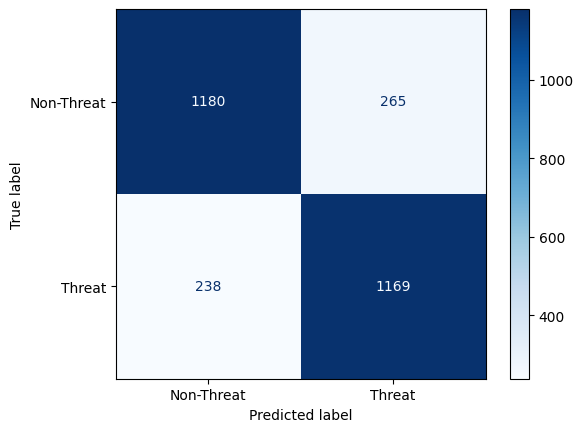

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assume y_true and y_pred are your true and predicted labels
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Threat", "Threat"])
disp.plot(cmap='Blues')